In [16]:
# AA228 Orbital Rendezvous – Results & Analysis
# Author: Sabrina Nicacio
# This notebook uses the closed-loop rendezvous simulation from `systems.py`

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import defaultdict
import pickle

from systems import run_closed_loop_episode
import json
from dataclasses import dataclass

In [ ]:
DEFAULT_CONFIG = {
    # --- simulation setup ---
    "dt": 1.0,                     # [s] simulation time step
    "N": 600,                      # number of time steps (horizon = N * dt secs) Can make it longer for better results
    "initial_state": (0,0,0,0,0,0),  # 6-state vector [x,y,z,xdot,ydot,zdot]

    # --- process / measurement noise scales (for Q and R) ---
    "sigma_pos": 10.0,             # [m] (not used directly here)
    "sigma_vel": 0.1,              # [m/s]
    "sigma_accel": 0.01,           # [m/s^2]
    "mean_motion": 0.0011,         # [rad/s] HCW mean motion n

    "sigma_accel_truth": 5e-4,     # [m/s^2] accel noise std for TRUE process noise Q
    "sigma_accel_model": 2e-5,     # [m/s^2] accel noise std for EKF model Q
    "sigma_meas_pos": 5.0,         # [m] per-axis position noise std for EKF R

    # --- initial state and belief (EKF) ---
    "x0_true": (10.0, 20.0, 22.0, 0.0, 0.0, 0.0),  # start ~50 m away
    "x0_hat_offset": (10.0, -5.0, -10.0, -0.2, 0.1, 0.9),
    "P0_diag": (10.0, 10.0, 10.0, 1.0, 1.0, 1.0),

    # --- reward shaping for the POMDP / MCTS ---
    # See reward function later in the code
    "reward": {
        "w_pos": 5.0,          # weight on ||position||^2
        "w_vel": 1,           # STRONGER weight on ||velocity||^2 to avoid huge speeds
        "w_u": 1e-6,            # weight on ||u||^2 for input
        "dock_bonus": 3000.0,  # big bonus when inside docking tolerances
        "dock_tol_pos": 2.0,    # [m]
        "dock_tol_vel": 0.2,   # [m/s]
        "v_impact_thresh": 1.0, # [m/s] inside tol_pos but faster than this → crash
        "big_crash_penalty": 5000.0,
        "alpha": 200.0,           # weight on progress term (prev_dist - new_dist)
    },

    "n_actions": 13
}

In [18]:
# Updating

CONFIG = {**DEFAULT_CONFIG, **{

    # --- initial state and belief (EKF) ---
    "x0_true": (10.0, 25.0, 22.0, 0.0, 0.0, 0.0),  # start ~50 m away
    "x0_hat_offset": (10.0, -5.0, -10.0, -0.2, 0.1, 0.9),
    "P0_diag": (10.0, 10.0, 10.0, 1.0, 1.0, 1.0),
}}
config_hash = json.dumps(CONFIG, sort_keys=True)

In [19]:
CONFIG

{'dt': 1.0,
 'N': 600,
 'initial_state': (0, 0, 0, 0, 0, 0),
 'sigma_pos': 10.0,
 'sigma_vel': 0.1,
 'sigma_accel': 0.01,
 'mean_motion': 0.0011,
 'sigma_accel_truth': 0.0005,
 'sigma_accel_model': 2e-05,
 'sigma_meas_pos': 5.0,
 'x0_true': (10.0, 25.0, 22.0, 0.0, 0.0, 0.0),
 'x0_hat_offset': (10.0, -5.0, -10.0, -0.2, 0.1, 0.9),
 'P0_diag': (10.0, 10.0, 10.0, 1.0, 1.0, 1.0),
 'reward': {'w_pos': 5.0,
  'w_vel': 1,
  'w_u': 1e-06,
  'dock_bonus': 3000.0,
  'dock_tol_pos': 2.0,
  'dock_tol_vel': 0.2,
  'v_impact_thresh': 1.0,
  'big_crash_penalty': 5000.0,
  'alpha': 200.0},
 'n_actions': 13}

In [36]:


plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["font.size"] = 12

dt = CONFIG["dt"]
N = CONFIG["N"]
t = np.arange(N + 1) * dt

dock_pos_tol = CONFIG["reward"]["dock_tol_pos"]
dock_vel_tol = CONFIG["reward"]["dock_tol_vel"]

def compute_metrics(res, seed):
    X_true = res["X_true"]          # (N+1, 6)
    X_hat = res["X_hat"]          # (N+1, 6)
    rewards = res["rewards"]        # (N,)
    actions = res["actions"]        # (N,)
    pos_norm = np.linalg.norm(X_true[:, :3], axis=1)
    vel_norm = np.linalg.norm(X_true[:, 3:], axis=1)

    final_dist = pos_norm[-1]
    min_dist = np.min(pos_norm)
    min_dist_step = np.argmin(pos_norm)
    min_dist_time = min_dist_step * dt

    cum_reward = np.cumsum(rewards)
    total_reward = cum_reward[-1]

    # docking condition: within both pos and vel tolerance
    dock_mask = (pos_norm <= dock_pos_tol) & (vel_norm <= dock_vel_tol)
    docked = np.any(dock_mask)
    dock_step = np.where(dock_mask)[0][0] if docked else CONFIG["N"]
    dock_time = dock_step * dt if docked else None

    return {
        "pos_norm": pos_norm,
        "vel_norm": vel_norm,
        "cum_reward": cum_reward,
        "final_dist": final_dist,
        "min_dist": min_dist,
        "min_dist_time": min_dist_time,
        "total_reward": total_reward,
        "docked": docked,
        "dock_step": dock_step,
        "dock_time": dock_time,

        "seed": seed,
        "X_true": X_true,
        "X_hat": X_hat,
        "rewards": rewards,
        "actions": actions
    }

def print_metrics(metrics, title="Episode metrics"):
    print(f"=== {title} ===")
    print(f"Final distance to target: {metrics['final_dist']:.3f} m")
    print(f"Minimum distance to target: {metrics['min_dist']:.3f} m "
          f"(at t = {metrics['min_dist_time']:.1f} s)")
    print(f"Total reward: {metrics['total_reward']:.3f}")
    if metrics["docked"]:
        print(f"Docked: YES at t = {metrics['dock_time']:.1f} s "
              f"(step {metrics['dock_step']})")
    else:
        print("Docked: NO (never simultaneously inside pos & vel tolerances)")
    print()





In [21]:

# run a single "baseline" episode
seed = 42   # can change this and re-run
res = run_closed_loop_episode(CONFIG, seed=seed)




metrics = compute_metrics(res, seed)
dock_step = metrics['dock_step']

X_true = res["X_true"][:dock_step]
X_hat = res["X_hat"][:dock_step]
actions = res["actions"][:dock_step]
rewards = res["rewards"][:dock_step]

t = np.arange(dock_step) * dt

print_metrics(metrics, title=f"Episode (seed={seed})")

Created simulation lasting 600.00 sec (10.00 min) with 600 steps
[DEBUG] k=0, x = 34.77067409031682 m, u_x = +0.000e+00 m/s^2, x_next =   10.000 m, a_k = 0, r =    0.001
[DEBUG] k=10, x = 34.408211730412674 m, u_x = -1.000e-02 m/s^2, x_next =   10.085 m, a_k = 2, r =   18.584
[DEBUG] k=20, x = 33.54787633529283 m, u_x = +0.000e+00 m/s^2, x_next =   10.627 m, a_k = 10, r =   21.660
[DEBUG] k=30, x = 31.243323708215293 m, u_x = +0.000e+00 m/s^2, x_next =   11.315 m, a_k = 10, r =   61.036
[DEBUG] k=40, x = 27.590461863658465 m, u_x = +0.000e+00 m/s^2, x_next =   11.642 m, a_k = 10, r =   83.938
[DEBUG] k=50, x = 22.728945464879523 m, u_x = -4.000e-02 m/s^2, x_next =   11.342 m, a_k = 8, r =  112.106
[DEBUG] k=60, x = 16.25492236468973 m, u_x = +1.000e-02 m/s^2, x_next =    9.909 m, a_k = 1, r =  135.957
[DEBUG] k=70, x = 9.735031844438664 m, u_x = +0.000e+00 m/s^2, x_next =    7.489 m, a_k = 6, r =  111.317
[DEBUG] k=80, x = 8.687106488897845 m, u_x = +0.000e+00 m/s^2, x_next =    4.128 

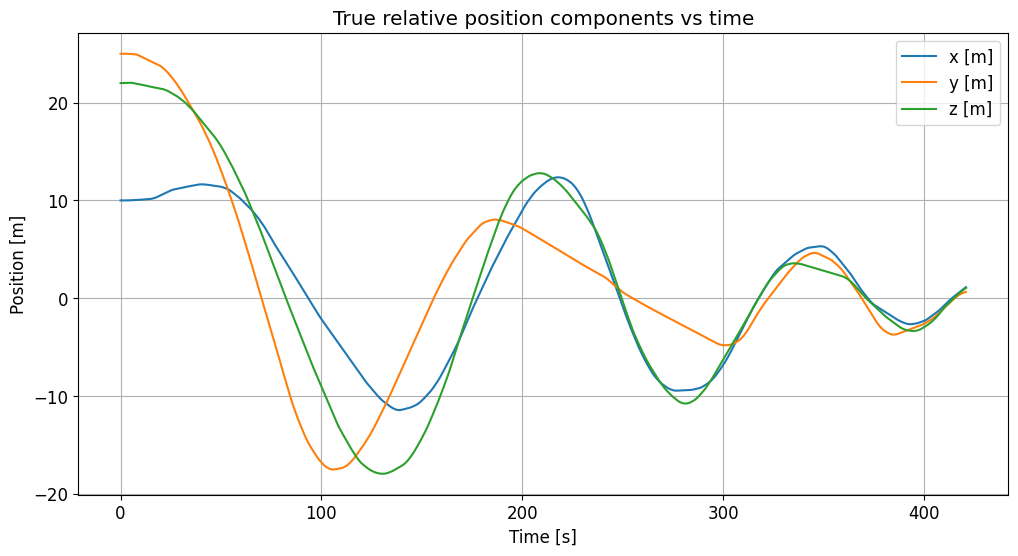

In [22]:

# plot 1 – position components vs time
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, X_true[:, 0], label="x [m]")
ax.plot(t, X_true[:, 1], label="y [m]")
ax.plot(t, X_true[:, 2], label="z [m]")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Position [m]")
ax.set_title("True relative position components vs time")
ax.legend()
ax.grid(True)
plt.show()

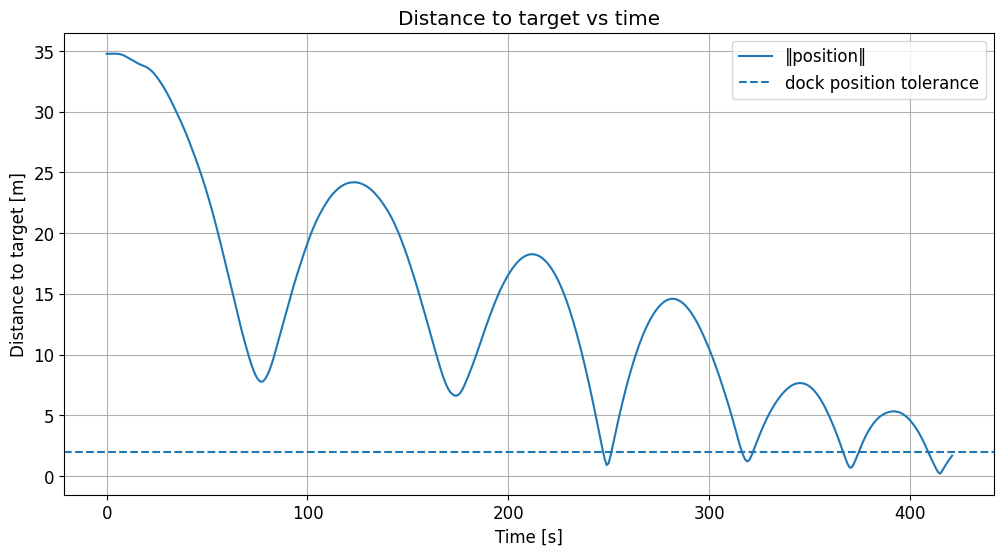

In [23]:
# plot 2 – distance to target vs time (with docking tolerance)
pos_norm = metrics["pos_norm"][:dock_step]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, pos_norm, label="‖position‖")
ax.axhline(dock_pos_tol, linestyle="--", label="dock position tolerance")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Distance to target [m]")
ax.set_title("Distance to target vs time")
ax.legend()
ax.grid(True)
plt.show()

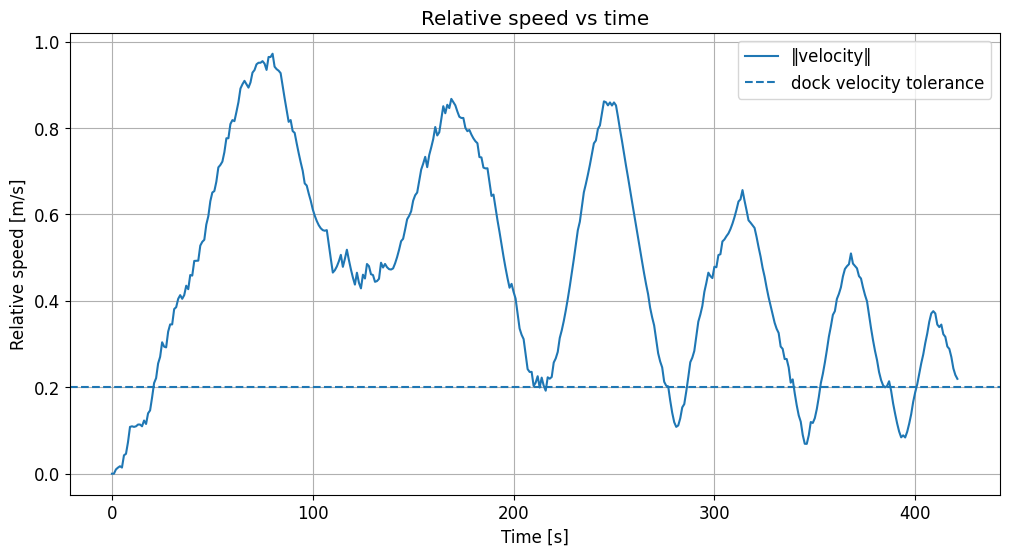

In [24]:
# plot 3 – velocity norm vs time (with docking tolerance)
vel_norm = metrics["vel_norm"][:dock_step]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t, vel_norm, label="‖velocity‖")
ax.axhline(dock_vel_tol, linestyle="--", label="dock velocity tolerance")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Relative speed [m/s]")
ax.set_title("Relative speed vs time")
ax.legend()
ax.grid(True)
plt.show()

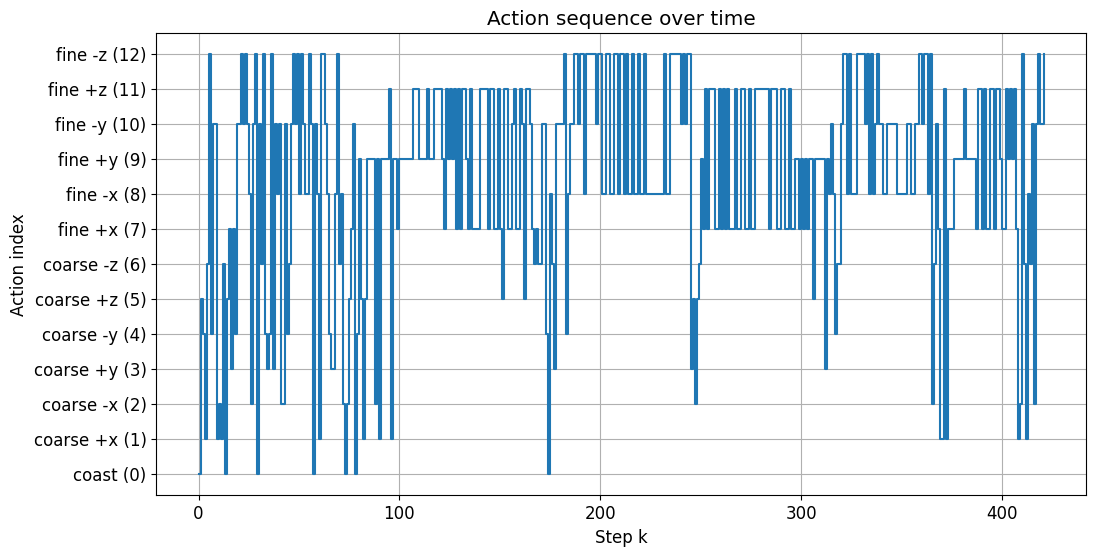

In [25]:
# plot 4 – action sequence vs time
# actions: 0 = coast, 1 = fine thrust, 2 = coarse thrust

fig, ax = plt.subplots(figsize=(12,6))
ax.step(np.arange(len(actions)), actions, where="post")
ax.set_xlabel("Step k")
ax.set_ylabel("Action index")
ax.set_title("Action sequence over time")
ax.set_yticks(np.arange(13))
ax.set_yticklabels(["coast (0)", 
                    "coarse +x (1)", 
                    "coarse -x (2)", 
                    "coarse +y (3)", 
                    "coarse -y (4)", 
                    "coarse +z (5)", 
                    "coarse -z (6)", 
                    "fine +x (7)", 
                    "fine -x (8)", 
                    "fine +y (9)", 
                    "fine -y (10)", 
                    "fine +z (11)", 
                    "fine -z (12)", 
                    ])
ax.grid(True)
plt.show()

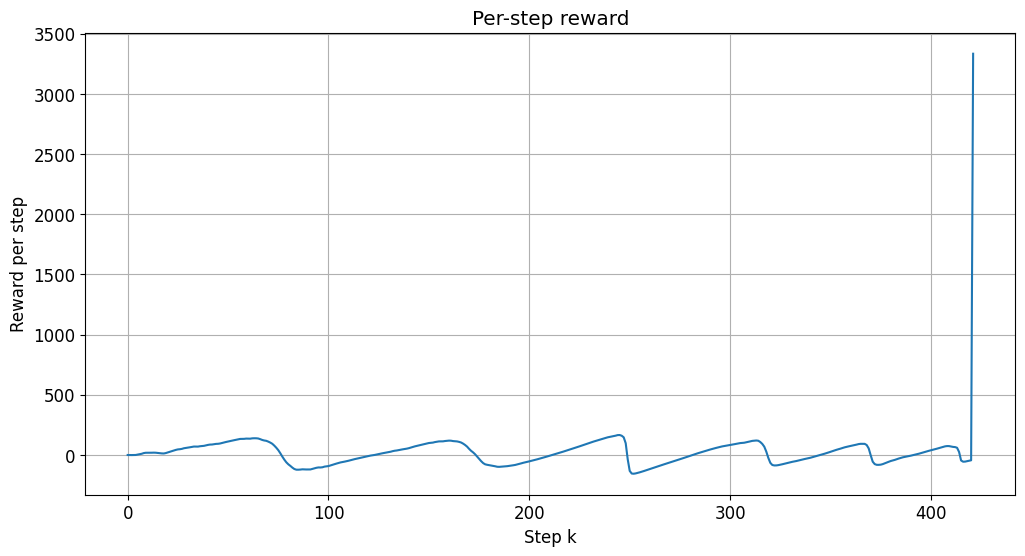

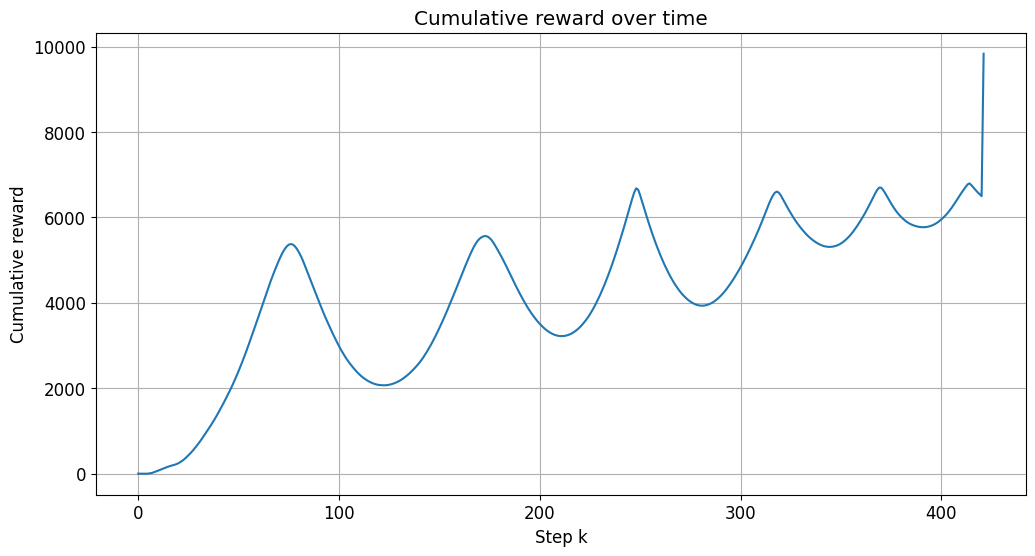

In [26]:
# lot 5 – per-step reward and cumulative reward
cum_reward = metrics["cum_reward"][:dock_step]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(len(rewards)), rewards)
ax.set_xlabel("Step k")
ax.set_ylabel("Reward per step")
ax.set_title("Per-step reward")
ax.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(len(cum_reward)), cum_reward)
ax.set_xlabel("Step k")
ax.set_ylabel("Cumulative reward")
ax.set_title("Cumulative reward over time")
ax.grid(True)
plt.show()

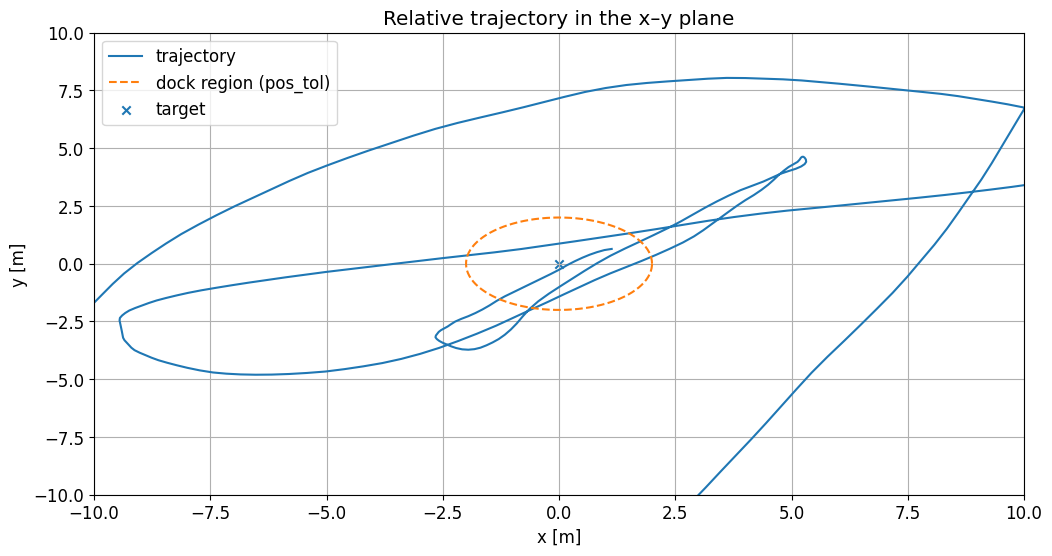

In [27]:
# plot 6 – 2D trajectory in x–y with docking region
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(X_true[:, 0], X_true[:, 1], label="trajectory")

# draw docking circle in x–y plane (z ignored)
theta = np.linspace(0, 2 * np.pi, 200)
ax.plot(dock_pos_tol * np.cos(theta),
        dock_pos_tol * np.sin(theta),
        linestyle="--",
        label="dock region (pos_tol)")

ax.scatter([0.0], [0.0], marker="x", label="target")
# ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_xlim((-10,10))
ax.set_ylim((-10,10))
# ax.set_ylabel("y [m]")
ax.set_title("Relative trajectory in the x–y plane")
ax.legend()
ax.grid(True)
plt.show()

In [28]:
def create_sphere(x_center, y_center, z_center, radius, resolution=50):
    """
    Returns the coordinates for plotting a sphere centered at (x_center, y_center, z_center).
    """
    # Create a grid of theta (longitude) and phi (latitude) angles
    u, v = np.mgrid[0:2*np.pi:resolution*1j, 0:np.pi:resolution*1j]
    
    # Calculate Cartesian coordinates
    x = radius * np.cos(u) * np.sin(v) + x_center
    y = radius * np.sin(u) * np.sin(v) + y_center
    z = radius * np.cos(v) + z_center
    
    return x, y, z

# Define sphere parameters
center = (0, 0, 0)
radius = CONFIG["reward"]["dock_tol_pos"]
x_coords, y_coords, z_coords = create_sphere(center[0], center[1], center[2], radius)

# Create the figure
fig = go.Figure(data=[])

In [29]:
# plot orbits 
fig = go.Figure()

# --- gather all orbits in one big array ---
all_x = []
all_y = []
all_z = []
all_colors = []


# Convert to arrays
all_x = np.array(all_x)
all_y = np.array(all_y)
all_z = np.array(all_z)
all_colors = np.array(all_colors)

fig.add_scatter3d(
    x=X_true[:, 0],
    y=X_true[:, 1],
    z=X_true[:, 2],
    mode="lines",
    # marker=dict(
    #     size=2,
    #     color=all_colors,
    #     colorscale=cmap,
    #     cmin=0,
    #     cmax=upper_z_value,
    #     colorbar=dict(
    #         title="GDOP",
    #         thickness=20,
    #         len=0.8
    #     )
    # ),
    showlegend=False
)

color1 = 'blue'
color2 = 'red'

fig.add_surface(x=x_coords, y=y_coords, z=z_coords, colorscale=[[0, color1], [1,color1]], opacity=0.3)


# pnt.plot.plot_arrow3(fig, rover_mcmf_m[0] / 1000,(earth_mcmf_m[0] - rover_mcmf_m[0])/15000, tip_scale = .15, width = 5, color='red')
fig.update_layout(showlegend=False, width=1000, height=800,
  scene=dict(
    xaxis=dict(title="X [m]"),
    yaxis=dict(title="Y [m]"),
    zaxis=dict(title="Z [m]"),
  ),
)

# frames = []

# if make_gif:
#   for i,angle in enumerate(np.linspace(0, 360, 60)):   # 60 frames
#     print(f"Animating frame {i}")

#     )
#     frames.append(imageio.v2.imread(fig.to_image(format="png", width=1000, height=800)))

#   imageio.mimsave("data/moon_rotation_mult_alt_new.gif", frames, fps=10, loop=0)

fig.show()

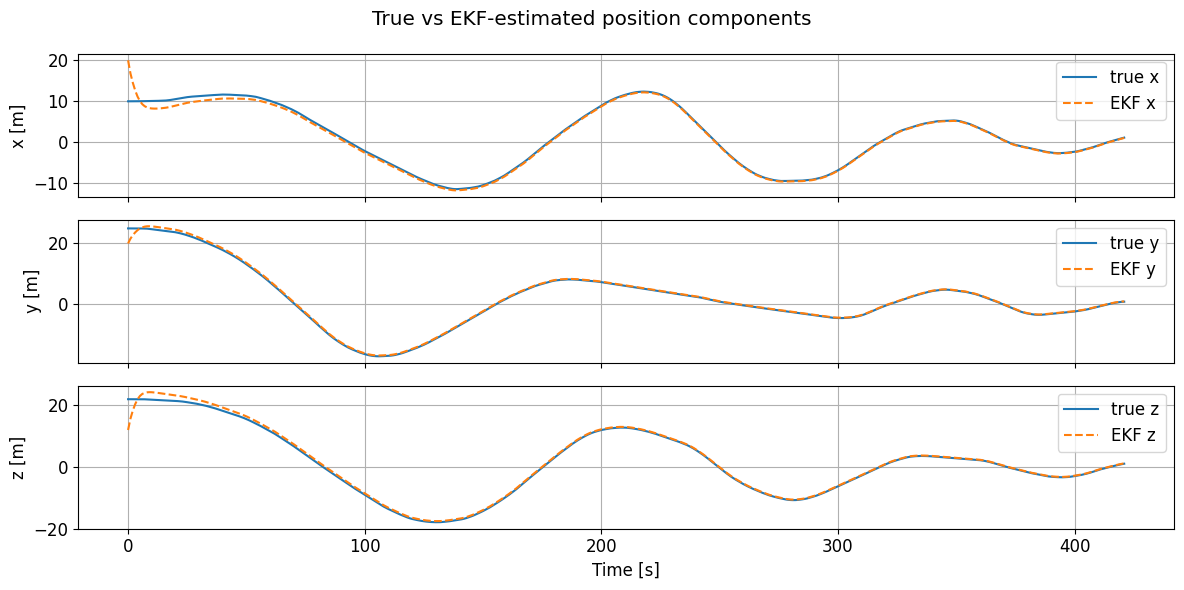

In [30]:
# plot 7 – true vs estimated position (EKF performance)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,6))

labels = ["x", "y", "z"]
for i in range(3):
    axs[i].plot(t, X_true[:, i], label=f"true {labels[i]}")
    axs[i].plot(t, X_hat[:, i], linestyle="--", label=f"EKF {labels[i]}")
    axs[i].set_ylabel(f"{labels[i]} [m]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
fig.suptitle("True vs EKF-estimated position components")
plt.tight_layout()
plt.show()

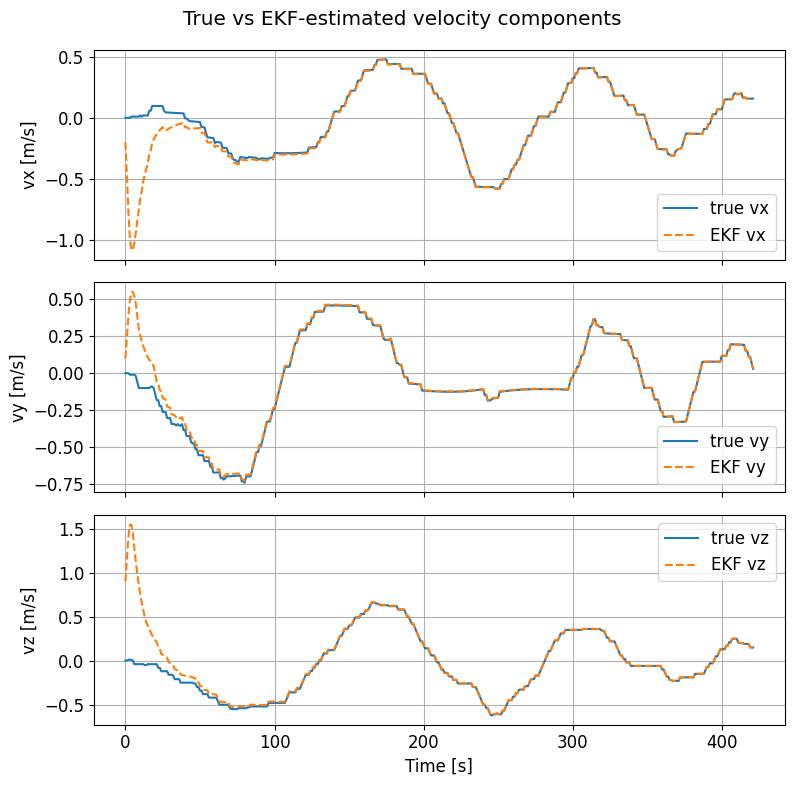

In [31]:
# plot 8 – true vs estimated velocity (EKF performance)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

labels = ["vx", "vy", "vz"]
for i in range(3):
    axs[i].plot(t, X_true[:, 3 + i], label=f"true {labels[i]}")
    axs[i].plot(t, X_hat[:, 3 + i], linestyle="--", label=f"EKF {labels[i]}")
    axs[i].set_ylabel(f"{labels[i]} [m/s]")
    axs[i].grid(True)
    axs[i].legend()

axs[-1].set_xlabel("Time [s]")
fig.suptitle("True vs EKF-estimated velocity components")
plt.tight_layout()
plt.show()

In [32]:
# Each config can have multiple seeds, and each seed corresponds to a run
@dataclass
class Config:
    config_dict: dict
    simulations: dict[int, dict] # Maps seed to a results simulation

# The results basically use configs as the "key" to a dictionary of that config's seeds/results
@dataclass
class Results:
    by_config: dict[str, Config] # config_hash to Config

In [ ]:
# experiment – run multiple seeds and compare
start_seed = 100
num_seeds = 20
seed_list = list(range(start_seed, start_seed + num_seeds))

all_metrics = []
all_results = []

for sd in seed_list:
    res_sd = run_closed_loop_episode(CONFIG, seed=sd)
    m_sd = compute_metrics(res_sd, seed=sd)
    print_metrics(m_sd, title=f"Episode (seed={sd})")
    all_metrics.append(m_sd)

Created simulation lasting 600.00 sec (10.00 min) with 600 steps
[DEBUG] k=0, x = 34.77427030043216 m, u_x = +0.000e+00 m/s^2, x_next =   10.000 m, a_k = 3, r =   -0.719
[DEBUG] k=10, x = 34.82166745351324 m, u_x = +0.000e+00 m/s^2, x_next =   10.111 m, a_k = 5, r =   -2.283
[DEBUG] k=20, x = 34.93054692313012 m, u_x = +0.000e+00 m/s^2, x_next =    9.571 m, a_k = 4, r =    5.866
[DEBUG] k=30, x = 33.91462828796074 m, u_x = +0.000e+00 m/s^2, x_next =    8.347 m, a_k = 12, r =   31.531
[DEBUG] k=40, x = 31.420184782133827 m, u_x = +0.000e+00 m/s^2, x_next =    6.791 m, a_k = 10, r =   68.466
[DEBUG] k=50, x = 26.92250456963593 m, u_x = +0.000e+00 m/s^2, x_next =    5.170 m, a_k = 12, r =  110.730
[DEBUG] k=60, x = 20.251218794532157 m, u_x = +0.000e+00 m/s^2, x_next =    3.454 m, a_k = 10, r =  154.977
[DEBUG] k=70, x = 11.142933288997328 m, u_x = +0.000e+00 m/s^2, x_next =    1.607 m, a_k = 10, r =  196.155
[DEBUG] k=80, x = 2.3572116929807403 m, u_x = +0.000e+00 m/s^2, x_next =   -0.56

KeyboardInterrupt: 

In [ ]:
print(all_metrics[0].keys())

In [ ]:

for sd, metric in zip(seed_list, all_metrics):

    dock_step = metric["dock_step"]

    if dock_step is None:
        dock_step = CONFIG["N"]
    t = np.arange(dock_step) * dt
    # plot distance traces as "spaghetti" to show variability
    plt.plot(t, metric["pos_norm"][:dock_step], alpha=0.7, label=f"seed {sd}")

plt.axhline(dock_pos_tol, linestyle="--", label="dock pos tol")
plt.xlabel("Time [s]")
plt.ylabel("Distance to target [m]")
plt.title("Distance vs time for multiple seeds")
plt.legend()
plt.grid(True)
plt.show()

# print a small table of summary metrics
print("=== Summary over multiple seeds ===")
for sd, m_sd in zip(seed_list, all_metrics):
    print(f"Seed {sd}: final_dist = {m_sd['final_dist']:.2f} m, "
          f"min_dist = {m_sd['min_dist']:.2f} m, "
          f"total_reward = {m_sd['total_reward']:.1f}, "
          f"docked = {m_sd['docked']}", end="")
    if m_sd["docked"]:
        print(f" at step {m_sd["dock_step"]}")
    else:
        print()

In [56]:
"""Crazy data-saving structure

dictionary that maps a config dictionary to results dictionary
{
    frozenset(config_stuff): [
        results, results, results
    ]
}

"""


load_from_cache = True
save_to_cache = False

if load_from_cache:
    with open("cache/results","rb") as f:
        all_results: Results = pickle.load(f)
        print(f"Loaded with {len(all_results.by_config)} configs")

else:
    all_results = defaultdict(dict)
# all_configs = defaultdict(defaultdict(list))

# print(all_results.by_config[config_hash].simulations[43])

# for metric in all_metrics:
#     seed = metric["seed"]
#     all_results.by_config[config_hash].simulations[seed] = metric

# print(all_results.by_config[config_hash].simulations.keys())

# only_keys = [20, 21, 22, 23, 24]

# filtered_dict = {key: all_results.by_config[config_hash].simulations[key] for key in only_keys if key in all_results.by_config[config_hash].simulations}


# all_results.by_config[config_hash].simulations = filtered_dict
# if save_to_cache:
#     with open("cache/results","wb") as f:
#         pickle.dump(all_results, f)
#         print(f"Saved with {len(all_results)} configs")

sims_dict = all_results.by_config[config_hash].simulations

print(sims_dict.keys())


Loaded with 1 configs
dict_keys([400, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608])


In [52]:
# plt.plot(sims_dict[400]["X_hat"][:,0])
# plt.plot(sims_dict[400]["X_true"][:,0])

In [38]:
all_results.by_config[config_hash].simulations = {}

In [39]:
with open("cache/results","wb") as f:
    pickle.dump(all_results, f)
    print(f"Saved with {len(all_results.by_config)} configs")

Saved with 1 configs


In [ ]:

for seed, metric in sims_dict.items():

    dock_step = metric["dock_step"]

    if dock_step is None:
        dock_step = CONFIG["N"]
    t = np.arange(dock_step) * dt
    # plot distance traces as "spaghetti" to show variability
    plt.plot(t, metric["pos_norm"][:dock_step], alpha=0.7, label=f"seed {metric["seed"]}")

plt.axhline(dock_pos_tol, linestyle="--", label="dock pos tol")
plt.xlabel("Time [s]")
plt.ylabel("Distance to target [m]")
plt.title("Distance vs time for multiple seeds")
plt.legend()
plt.grid(True)
plt.show()

# # print a small table of summary metrics
# print("=== Summary over multiple seeds ===")
# for sd, m_sd in zip(seed_list, all_metrics):
#     print(f"Seed {sd}: final_dist = {m_sd['final_dist']:.2f} m, "
#           f"min_dist = {m_sd['min_dist']:.2f} m, "
#           f"total_reward = {m_sd['total_reward']:.1f}, "
#           f"docked = {m_sd['docked']}", end="")
#     if m_sd["docked"]:
#         print(f" at step {m_sd["dock_step"]}")
#     else:
#         print()



In [40]:
def run_seeds(start_seed, num_seeds):# experiment – run multiple seeds and compare
    seed_list = list(range(start_seed, start_seed + num_seeds))

    all_metrics = []

    for sd in seed_list:
        res_sd = run_closed_loop_episode(CONFIG, seed=sd, debug=False)
        m_sd = compute_metrics(res_sd, seed=sd)
        print_metrics(m_sd, title=f"Episode (seed={sd})")
        all_metrics.append(m_sd)

    with open("cache/results","rb") as f:
        all_results: Results = pickle.load(f)
        print(f"Loaded with {len(all_results.by_config)} configs")

    print(f"{len(all_results.by_config[config_hash].simulations.keys())}")
    for metric in all_metrics:
        seed = metric["seed"]
        all_results.by_config[config_hash].simulations[seed] = metric
    print(f"{len(all_results.by_config[config_hash].simulations.keys())}")

    with open("cache/results","wb") as f:
        pickle.dump(all_results, f)
        print(f"Saved with {len(all_results.by_config)} configs")

In [53]:
num = 1
for i in range(500,10000, num):
    print(f"Starting {num} at {i}")
    run_seeds(i,num)

Starting 1 at 500
Created simulation lasting 600.00 sec (10.00 min) with 600 steps
=== Episode (seed=500) ===
Final distance to target: 0.000 m
Minimum distance to target: 0.000 m (at t = 484.0 s)
Total reward: 9808.897
Docked: YES at t = 484.0 s (step 484)

Loaded with 1 configs
1
2
Saved with 1 configs
Starting 1 at 501
Created simulation lasting 600.00 sec (10.00 min) with 600 steps
=== Episode (seed=501) ===
Final distance to target: 3.173 m
Minimum distance to target: 0.241 m (at t = 569.0 s)
Total reward: 6164.523
Docked: NO (never simultaneously inside pos & vel tolerances)

Loaded with 1 configs
2
3
Saved with 1 configs
Starting 1 at 502
Created simulation lasting 600.00 sec (10.00 min) with 600 steps
=== Episode (seed=502) ===
Final distance to target: 0.000 m
Minimum distance to target: 0.000 m (at t = 447.0 s)
Total reward: 9845.352
Docked: YES at t = 447.0 s (step 447)

Loaded with 1 configs
3
4
Saved with 1 configs
Starting 1 at 503
Created simulation lasting 600.00 sec (1

KeyboardInterrupt: 

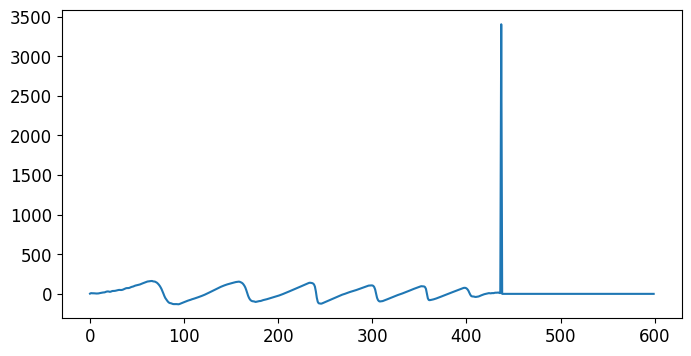

In [62]:
plt.plot(all_results.by_config[config_hash].simulations[503]["rewards"])

In [54]:


# plot orbits 
fig = go.Figure()

# --- gather all orbits in one big array ---
all_x = []
all_y = []
all_z = []
all_colors = []


# Convert to arrays
all_x = np.array(all_x)
all_y = np.array(all_y)
all_z = np.array(all_z)
all_colors = np.array(all_colors)

# X_true = all_results.by_config[config_hash].simulations[20]["X_true"]
for run in all_results.by_config[config_hash].simulations.values():
    fig.add_scatter3d(
        x=run["X_true"][:, 0],
        y=run["X_true"][:, 1],
        z=run["X_true"][:, 2],
        mode="lines",
        showlegend=False
    )

color1 = 'blue'
color2 = 'red'

fig.add_surface(x=x_coords, y=y_coords, z=z_coords, colorscale=[[0, color1], [1,color1]], opacity=0.3)

fig.update_layout(showlegend=False, width=1000, height=800,
  scene=dict(
    xaxis=dict(title="X [m]"),
    yaxis=dict(title="Y [m]"),
    zaxis=dict(title="Z [m]"),
  ),
)
fig.show()